# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence...  

In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_simp_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import warnings
import datetime
import os
import shutil 

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [6]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
path = './vpod_1.1_data_splits_2024-05-02_16-58-09'
# path to sequences of interest
seqFileName = f'{path}/inv_only_aligned_VPOD_1.1_het.fasta' 
# path to corresponding metadata of interest
metaDataFileName = f'{path}/inv_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.60

#Whether or not you want to drop the reference sequence from the training data- Usually 'Bovine' or 'Squid'
drop_ref = False


In [7]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('/')[2]
#print(seqFile)
seqFile = seqFile.split('.')[0]
#print(seqFile)
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [8]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
# importing sequences data
print('reading fasta file')

tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)

shutil.copy2(f'{seqFileName}',report_dir)
write_fasta(dat = tr, fasta_file = f'{seqFile}_gap_dropped.fasta' , report_dir = report_dir)

reading meta-data
reading fasta file
inv_only_aligned_VPOD_1_gap_dropped.fasta was saved successfully
CPU times: total: 156 ms
Wall time: 143 ms


In [9]:
try:
    reference_seq = tr.loc['Bovine'].copy()
    ref_seq_name = 'bovine'
    if drop_ref == True:
        meta_data = meta_data.drop('Bovine')
    #print(bovine)
except:
    reference_seq = tr.loc['Squid'].copy()
    ref_seq_name = 'squid'
    #print(squid)
reference_seq.to_csv(path_or_buf= f'{report_dir}/ref_sequence.csv',index = True,mode="w")

In [10]:
tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
tr.shape

(156, 386)

In [11]:
tr.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p377,p378,p379,p380,p381,p382,p383,p384,p385,Lambda_Max
Squid,M,G,R,D,L,R,D,N,E,T,...,A,Q,K,Q,Q,Q,A,A,Y,473.0
S1,M,A,L,N,Y,L,N,T,G,A,...,V,C,E,E,K,A,P,A,NaN,571.0
S2,M,A,M,D,S,L,D,P,G,A,...,V,C,E,E,K,P,S,A,NaN,540.0
S3,M,A,M,D,S,L,D,P,G,A,...,V,C,E,E,K,P,S,A,NaN,538.0
S4,M,A,M,D,S,L,D,P,G,A,...,V,C,E,E,K,P,S,A,NaN,542.0


In [12]:
import numpy as np
import csv
import pandas as pd

In [13]:
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

Shape of data is:  (156, 385)


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [14]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


,Lambda_Max,Species,Opsin_Family,Phylum,Class,Accession,Mutations
Squid,473.0,Todarodes_pacificus,Rh1,Mollusca,Cephalopoda,X70498,NaN
S1,571.0,Papilio_xuthus,IV-Rh3,Arthropoda,Insecta,AB007425.1,NaN
S2,540.0,Papilio_xuthus,IV-Rh1,Arthropoda,Insecta,AB007423.1,NaN
S3,538.0,Papilio_xuthus,"IV-Rh1,IV-Rh3",Arthropoda,Insecta,AB007423.1_1_58-AB007425.1_59_83-AB007423.1_84...,NaN
S4,542.0,Papilio_xuthus,"IV-Rh1,IV-Rh3",Arthropoda,Insecta,AB007423.1_1_58-AB007425.1_59_83-AB007423.1_84...,NaN


In [15]:
print('sequence data looks like this:')
tr.head()

sequence data looks like this:


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p376,p377,p378,p379,p380,p381,p382,p383,p384,p385
Squid,M,G,R,D,L,R,D,N,E,T,...,A,A,Q,K,Q,Q,Q,A,A,Y
S1,M,A,L,N,Y,L,N,T,G,A,...,A,V,C,E,E,K,A,P,A,NaN
S2,M,A,M,D,S,L,D,P,G,A,...,A,V,C,E,E,K,P,S,A,NaN
S3,M,A,M,D,S,L,D,P,G,A,...,A,V,C,E,E,K,P,S,A,NaN
S4,M,A,M,D,S,L,D,P,G,A,...,A,V,C,E,E,K,P,S,A,NaN


In [16]:
import random
from collections import Counter
#from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import esm


from sklearn.decomposition import PCA

In [17]:
index_names = tr.index.to_list()

In [18]:
EMB_PATH = "C:/Users/safra/Documents/GitHub/visual-physiology-opsin-db/vpod_data/VPOD_1.1/formatted_database_subsets/vpod_1.1_data_subsets_2024-05-02/inv_gap_dropped_esm_v1" # Path to directory of embeddings
EMB_LAYER = 33

In [19]:
Xs = []
for indx in index_names:
    fn = f'{EMB_PATH}/{indx}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(Xs.shape)

(156, 1280)


In [20]:
print(Xs)

[[-0.2055997   0.17137364 -0.17658164 ... -0.13138705  0.1727172
  -0.15794206]
 [-0.27599177  0.11815701 -0.16573305 ... -0.16623507  0.16567256
  -0.20453598]
 [-0.30769405  0.11963197 -0.16723208 ... -0.16604513  0.158003
  -0.17454426]
 ...
 [-0.19249369  0.15530045 -0.18012947 ... -0.17320141  0.16751598
  -0.18618253]
 [-0.25137278  0.15755974 -0.18869974 ... -0.15642159  0.15895481
  -0.20122518]
 [-0.24800645  0.15782069 -0.18738726 ... -0.1519618   0.1615981
  -0.20011476]]


In [35]:
selected_elements = ['p45','p48','p51','p82','p85','p89','p92','p117','p121','p123','p131','p179','p196','p229','p232','p276','p284','p291','p297','p298','p299','p307']


In [21]:
col_names3 = []
for col in selected_elements:
    col_names3.append(f'p{col+1}')

In [28]:
import numpy as np

# Initialize an empty array of objects with the desired shape
nested_array = np.empty((362, 357), dtype=object)

# Populate the new array with the 1D arrays from the original array
for i in range(Xs.shape[0]):
    for j in range(Xs.shape[1]):
        nested_array[i, j] = Xs[i, j, :]

# Verify the shape and types
print(nested_array.shape)  # Should print (362, 357)

(362, 357)


In [29]:
print(nested_array)

[[array([ 0.54810447,  0.36825255, -0.23185155, ...,  0.01698308,
          0.05210298, -0.24628061], dtype=float32)
  array([ 0.2646546 ,  0.4729845 , -0.03050584, ..., -0.03784935,
          0.13479543, -0.5107386 ], dtype=float32)
  array([ 0.16850394,  0.67071587, -0.22219056, ...,  0.02562221,
         -0.12273373, -0.12985101], dtype=float32)                ...
  array([ 0.07865681,  0.31925687, -0.04357469, ..., -0.09413476,
          0.05279792,  0.10360031], dtype=float32)
  array([ 0.31828526,  0.5951352 , -0.28392875, ..., -0.44551933,
          0.6385577 , -0.18055649], dtype=float32)
  array([-0.0055929 , -0.04993413, -0.15741055, ..., -0.419166  ,
          0.16713378, -0.03373177], dtype=float32)               ]
 [array([ 0.6024632 ,  0.3743074 , -0.22638762, ...,  0.05412875,
          0.05895057, -0.26761335], dtype=float32)
  array([ 0.32070965,  0.54485655,  0.03476263, ...,  0.01663357,
          0.09485299, -0.46534294], dtype=float32)
  array([ 0.07756095,  0.6562

In [21]:
col_names = []
for col in range(Xs.shape[1]):
    col_names.append(f'p{col+1}')
 

In [23]:
tr2 = pd.DataFrame(data = list(Xs), index=index_names, columns=col_names)
tr2

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p1271,p1272,p1273,p1274,p1275,p1276,p1277,p1278,p1279,p1280
Squid,-0.205600,0.171374,-0.176582,-0.049683,-0.789925,-0.198886,0.247154,-0.130291,0.118051,0.096749,...,-0.236077,-0.066622,0.098293,-0.209951,-0.230142,-0.028069,0.122714,-0.131387,0.172717,-0.157942
S1,-0.275992,0.118157,-0.165733,-0.077354,-0.823877,-0.184846,0.348423,-0.127355,0.175319,0.089056,...,-0.255305,-0.139456,0.127406,-0.178715,-0.117478,-0.084165,0.174441,-0.166235,0.165673,-0.204536
S2,-0.307694,0.119632,-0.167232,-0.091023,-0.860540,-0.175309,0.352046,-0.134891,0.192373,0.097315,...,-0.228233,-0.143010,0.130487,-0.192282,-0.133220,-0.079342,0.159340,-0.166045,0.158003,-0.174544
S3,-0.302478,0.118936,-0.162314,-0.090198,-0.859268,-0.173083,0.345290,-0.134703,0.186735,0.093678,...,-0.227252,-0.135186,0.141377,-0.190528,-0.134788,-0.072653,0.162768,-0.159548,0.161163,-0.171762
S4,-0.306847,0.122176,-0.160859,-0.086237,-0.855547,-0.174790,0.347065,-0.136774,0.185097,0.094267,...,-0.231898,-0.138848,0.141717,-0.190837,-0.130333,-0.076858,0.173356,-0.158358,0.158530,-0.176894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S151,-0.194600,0.157214,-0.180283,-0.086911,-0.811581,-0.222970,0.337315,-0.122662,0.107097,0.113266,...,-0.194463,-0.068467,0.084353,-0.187370,-0.134582,-0.063285,0.175463,-0.167072,0.164734,-0.185646
S152,-0.194614,0.157819,-0.181925,-0.091104,-0.822491,-0.225306,0.336477,-0.122364,0.109612,0.115406,...,-0.195744,-0.071679,0.087611,-0.187445,-0.136804,-0.066625,0.171918,-0.171238,0.161836,-0.185896
S153,-0.192494,0.155300,-0.180129,-0.091449,-0.813839,-0.225097,0.339481,-0.116930,0.107593,0.114608,...,-0.195868,-0.069998,0.082950,-0.186621,-0.135998,-0.064518,0.169555,-0.173201,0.167516,-0.186183
S154,-0.251373,0.157560,-0.188700,-0.078696,-0.772782,-0.222696,0.270699,-0.133738,0.161224,0.131384,...,-0.265896,-0.054811,0.113245,-0.201990,-0.141283,-0.027438,0.149182,-0.156422,0.158955,-0.201225


In [46]:
tr2_sub = tr2[selected_elements]
tr2_sub

,p45,p48,p51,p82,p85,p89,p92,p117,p121,p123,...,p196,p229,p232,p276,p284,p291,p297,p298,p299,p307
Bovine,"[-0.5545414, -0.004422741, -0.043054026, -0.22...","[-0.49197453, 0.40236926, 0.31722328, 0.200064...","[-0.41920367, 1.0684763, 0.455138, 0.37902802,...","[-1.269661, -0.30826768, -0.32487172, -0.14407...","[-0.6023009, 0.74178064, -0.38666463, -0.65290...","[-0.3192113, 0.9536797, 0.16008568, -0.3506921...","[-0.07036912, 0.4208721, -0.38920078, -0.65843...","[-0.8273015, 0.34191337, -0.15761074, 0.095248...","[-1.1095431, 0.77188283, 0.12455, 0.11433661, ...","[-0.8664396, 0.37084478, -0.3309614, 0.0269341...",...,"[0.32170328, -0.105583385, -0.43276712, 0.3173...","[-0.246714, 0.7557932, 0.052627273, 0.16463251...","[-0.01410529, 0.6311846, -0.22421765, -0.38997...","[0.40238392, 0.49230382, -0.7084188, 0.2890919...","[-0.056768678, 0.2666226, 0.0346782, -0.153838...","[-0.1285975, 0.32281223, -0.0437254, -0.380655...","[-0.6141489, 0.7549006, -0.24662429, -0.219579...","[0.3798978, 0.02033129, 0.22572519, -0.5231275...","[0.10549129, 1.1319686, 0.41556153, -0.5845399...","[0.29066703, 0.40478334, 0.47278532, 0.5788281..."
S1,"[-0.741882, -0.0023061242, -0.12560366, -0.039...","[-0.47369188, 0.41009906, 0.45048252, 0.120550...","[-0.39672533, 0.94980985, 0.44191214, 0.286357...","[-1.1833887, -0.2328665, -0.2398758, -0.189508...","[-0.5775772, 0.74548864, -0.39640474, -0.52196...","[-0.28609937, 0.84088945, 0.1265275, -0.282856...","[-0.031132191, 0.49321106, -0.24830934, -0.389...","[-0.858661, 0.2827733, -0.0020849686, 0.085598...","[-1.152469, 0.620679, 0.40350598, 0.10081958, ...","[-0.63787645, 0.27581555, -0.16764003, 0.14933...",...,"[0.1969584, -0.102972895, -0.82670075, 0.34673...","[-0.12992086, 0.4226409, 0.17941377, -0.088915...","[-0.023982517, 0.56942683, -0.37601426, -0.412...","[0.4829938, 0.2702914, -0.58839005, 0.33528316...","[-0.10246907, 0.18135162, 0.12117525, 0.022955...","[-0.28240275, 0.22912782, -0.08551379, -0.3912...","[-0.6313907, 0.7681529, -0.37959787, -0.161205...","[0.28426594, -0.045952994, 0.23620765, -0.5325...","[-0.07669451, 1.1616141, 0.5182233, -0.7767346...","[0.21463802, 0.32978472, 0.37890297, 0.6647926..."
S2,"[-0.6407025, -0.015887953, -0.07962919, -0.058...","[-0.41838104, 0.38718435, 0.46925646, 0.153134...","[-0.4238653, 0.9052971, 0.3656402, 0.23173097,...","[-1.2250029, -0.23726015, -0.22997275, -0.1786...","[-0.58462065, 0.7295395, -0.4077435, -0.555166...","[-0.28826052, 0.8479692, 0.11916711, -0.306206...","[-0.012607891, 0.51620996, -0.2516662, -0.3874...","[-0.85835916, 0.24217272, -0.011479532, 0.0704...","[-1.1432933, 0.6218293, 0.41419417, 0.09748341...","[-0.62019145, 0.29286695, -0.19793639, 0.15722...",...,"[0.18147013, -0.092510074, -0.80890787, 0.3380...","[-0.13981201, 0.4377173, 0.20349126, -0.095300...","[-0.021546483, 0.57121515, -0.3427185, -0.4112...","[0.48812702, 0.27853984, -0.5706057, 0.3175903...","[-0.099202186, 0.1749832, 0.12865014, 0.029184...","[-0.27953535, 0.2166522, -0.077077955, -0.4094...","[-0.6425855, 0.73957074, -0.36941782, -0.16527...","[0.29588544, -0.050544504, 0.24325559, -0.5368...","[-0.0722424, 1.1443156, 0.5153849, -0.78754044...","[0.21584135, 0.32566145, 0.3724901, 0.670139, ..."
S3,"[-0.60390216, -0.08962202, 0.001015244, -0.150...","[-0.4073223, 0.45495653, 0.5032382, 0.18024954...","[-0.29540136, 0.9844914, 0.3191961, 0.22677766...","[-1.129459, -0.25909773, -0.21891192, -0.23653...","[-0.5570724, 0.7218231, -0.3818862, -0.6559991...","[-0.22196832, 0.85698634, 0.12258901, -0.35280...","[-0.0133090615, 0.53755176, -0.18473627, -0.42...","[-0.7928172, 0.2787275, 0.09566887, 0.18418978...","[-1.103505, 0.70472944, 0.45173752, 0.06562212...","[-0.7209482, 0.13324395, -0.05238814, 0.142658...",...,"[0.17275427, -0.13682176, -0.7785066, 0.258206...","[-0.13025407, 0.44866914, 0.1564638, -0.085187...","[-0.049131125, 0.61000663, -0.3768678, -0.4466...","[0.45621368, 0.23264378, -0.5598643, 0.3075679...","[-0.18994752, 0.17588

In [53]:
tr2_sub = tr2_sub.applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
tr2_sub

,p45,p48,p51,p82,p85,p89,p92,p117,p121,p123,...,p196,p229,p232,p276,p284,p291,p297,p298,p299,p307
Bovine,"[-0.5545414090156555, -0.004422741010785103, -...","[-0.49197453260421753, 0.40236926078796387, 0....","[-0.41920366883277893, 1.0684763193130493, 0.4...","[-1.2696609497070312, -0.3082676827907562, -0....","[-0.6023008823394775, 0.7417806386947632, -0.3...","[-0.31921130418777466, 0.9536796808242798, 0.1...","[-0.07036911696195602, 0.4208720922470093, -0....","[-0.8273015022277832, 0.3419133722782135, -0.1...","[-1.1095430850982666, 0.7718828320503235, 0.12...","[-0.8664395809173584, 0.3708447813987732, -0.3...",...,"[0.3217032849788666, -0.10558338463306427, -0....","[-0.24671399593353271, 0.7557932138442993, 0.0...","[-0.014105290174484253, 0.6311845779418945, -0...","[0.4023839235305786, 0.4923038184642792, -0.70...","[-0.05676867812871933, 0.2666226029396057, 0.0...","[-0.12859749794006348, 0.3228122293949127, -0....","[-0.6141489148139954, 0.7549005746841431, -0.2...","[0.379897803068161, 0.020331289619207382, 0.22...","[0.1054912880063057, 1.13196861743927, 0.41556...","[0.29066702723503113, 0.40478333830833435, 0.4..."
S1,"[-0.7418820261955261, -0.002306124195456505, -...","[-0.4736918807029724, 0.410099059343338, 0.450...","[-0.3967253267765045, 0.9498098492622375, 0.44...","[-1.1833887100219727, -0.23286649584770203, -0...","[-0.5775771737098694, 0.7454886436462402, -0.3...","[-0.286099374294281, 0.8408894538879395, 0.126...","[-0.03113219141960144, 0.4932110607624054, -0....","[-0.8586609959602356, 0.28277328610420227, -0....","[-1.1524690389633179, 0.6206790208816528, 0.40...","[-0.6378764510154724, 0.27581554651260376, -0....",...,"[0.19695839285850525, -0.10297289490699768, -0...","[-0.1299208551645279, 0.4226408898830414, 0.17...","[-0.023982517421245575, 0.5694268345832825, -0...","[0.48299381136894226, 0.27029138803482056, -0....","[-0.1024690717458725, 0.18135161697864532, 0.1...","[-0.28240275382995605, 0.22912782430648804, -0...","[-0.6313906908035278, 0.7681528925895691, -0.3...","[0.28426593542099, -0.045952994376420975, 0.23...","[-0.07669451087713242, 1.1616140604019165, 0.5...","[0.21463802456855774, 0.32978472113609314, 0.3..."
S2,"[-0.640702486038208, -0.015887953341007233, -0...","[-0.4183810353279114, 0.38718435168266296, 0.4...","[-0.42386528849601746, 0.9052971005439758, 0.3...","[-1.2250028848648071, -0.2372601479291916, -0....","[-0.5846206545829773, 0.7295395135879517, -0.4...","[-0.2882605195045471, 0.8479691743850708, 0.11...","[-0.012607891112565994, 0.5162099599838257, -0...","[-0.858359158039093, 0.2421727180480957, -0.01...","[-1.1432932615280151, 0.6218292713165283, 0.41...","[-0.6201914548873901, 0.29286694526672363, -0....",...,"[0.18147012591362, -0.09251007437705994, -0.80...","[-0.13981200754642487, 0.4377172887325287, 0.2...","[-0.021546483039855957, 0.5712151527404785, -0...","[0.4881270229816437, 0.27853983640670776, -0.5...","[-0.09920218586921692, 0.1749832034111023, 0.1...","[-0.27953535318374634, 0.21665219962596893, -0...","[-0.6425855159759521, 0.7395707368850708, -0.3...","[0.29588544368743896, -0.05054450407624245, 0....","[-0.07224240154027939, 1.1443156003952026, 0.5...","[0.2158413529396057, 0.32566145062446594, 0.37..."
S3,"[-0.6039021611213684, -0.08962202072143555, 0....","[-0.4073222875595093, 0.4549565315246582, 0.50...","[-0.29540136456489563, 0.9844914078712463, 0.3...","[-1.129459023475647, -0.25909772515296936, -0....","[-0.5570724010467529, 0.7218230962753296, -0.3...","[-0.22196832299232483, 0.8569863438606262, 0.1...","[-0.013309061527252197, 0.537551760673523, -0....","[-0.7928171753883362, 0.2787275016307831, 0.09...","[-1.10350501537323, 0.704729437828064, 0.45173...","[-0.7209482192993164, 0.13324394822120667, -0....",...,"[0.17275427281856537, -0.13682176172733307, -0...","[-0.13025407493114471, 0.4486691355705261, 0.1...","[-0.0491311252117157, 0.6100066304206848, -0.3...","[0.45621368288993835, 0.23264378309249878, -0....","[-0.18994751572608948

In [25]:
num_pca_components = 100
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs)

In [26]:
col_names2 = []
for col in range(num_pca_components):
    col_names2.append(f'p{col}')
 

In [27]:
tr3 = pd.DataFrame(data = Xs_train_pca, index=index_names, columns=col_names2)
tr3

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p90,p91,p92,p93,p94,p95,p96,p97,p98,p99
Squid,0.806748,-0.363196,0.469680,0.142741,0.227061,0.029301,-0.037392,0.591585,0.268071,0.200516,...,-0.000103,-0.000257,0.000125,-0.000129,-0.000089,0.000144,0.000272,0.000081,0.000043,0.000060
S1,-1.434968,0.749882,0.044782,0.047436,-0.019849,0.058007,-0.002904,-0.057730,0.026686,-0.047990,...,0.001117,-0.001706,-0.000023,-0.000105,0.000488,0.000907,-0.000434,0.000109,0.000708,-0.000260
S2,-1.475817,0.938345,-0.118197,0.134703,-0.159098,0.131558,0.087669,0.004470,-0.043308,0.057466,...,-0.001339,0.000477,0.003244,-0.000527,-0.000357,0.001728,0.001228,0.001107,0.004049,-0.005455
S3,-1.477218,0.912453,-0.133287,0.147072,-0.160074,0.159747,0.119603,0.043830,-0.061101,0.074277,...,-0.000881,-0.000077,-0.001186,-0.000340,-0.000657,-0.000947,-0.001082,-0.001093,0.002799,-0.003460
S4,-1.527757,0.923680,-0.156233,0.134790,-0.167774,0.126766,0.100677,0.052165,-0.056849,0.081010,...,-0.000547,-0.001078,-0.002985,-0.001603,-0.000231,0.003362,-0.000851,-0.001326,-0.000996,-0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S151,-0.535618,-0.065501,0.525671,-0.524255,0.099890,-0.043009,0.263181,0.016008,0.318646,-0.051086,...,0.000911,-0.001557,-0.001947,0.002887,0.001269,0.001017,0.000182,-0.005435,-0.005372,-0.005989
S152,-0.544707,-0.049087,0.518472,-0.526873,0.103755,-0.050753,0.251342,0.014682,0.327983,-0.053572,...,0.000986,-0.010568,-0.003092,0.010009,0.017835,0.003104,-0.002972,0.006547,0.007947,-0.003681
S153,-0.518245,-0.066462,0.530535,-0.528501,0.106859,-0.046651,0.275964,0.019098,0.323131,-0.060187,...,0.011487,-0.003385,0.016925,-0.007271,-0.010299,-0.004101,-0.004250,0.001265,0.003040,0.007096
S154,-0.573305,0.261549,0.364309,-0.016880,0.165594,0.037604,-0.074984,0.046049,-0.210057,-0.176763,...,0.000899,-0.004738,0.001127,0.003705,0.007700,0.001246,-0.004103,0.004568,0.006771,0.002159


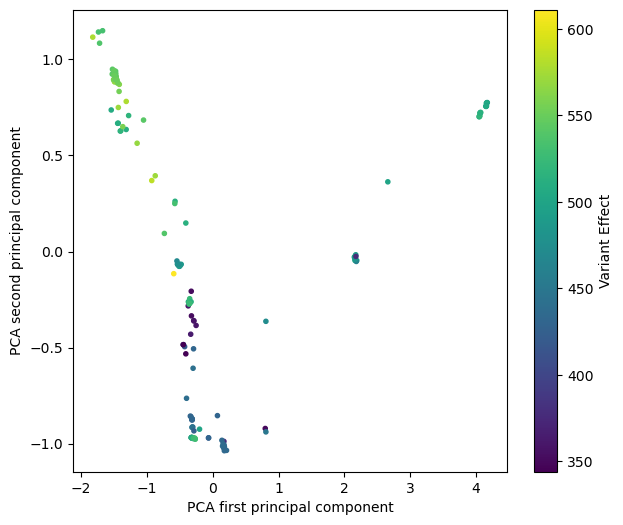

In [30]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=y, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [50]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.001, keep=False))
    ])

In [32]:
tr_hold = prep_pipeline[:5].fit_transform(tr)
tr_hold

,p1_E,p1_GAP,p1_H,p1_KRF,p1_M,p2_E,p2_G,p2_GAP,p2_H,p2_L,...,p384_D,p384_E,p384_G,p384_GAP,p385_E,p385_G,p385_GAP,p385_N,p385_SYPD,p385_T
Squid,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
S1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
S2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
S3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
S4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S151,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
S152,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
S153,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
S154,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [33]:
tr4 = tr_hold.merge(tr2,  left_index=True, right_index=True)
tr4.shape

(156, 2844)

In [34]:
tr5 = tr_hold.merge(tr3,  left_index=True, right_index=True)
tr5.shape

(156, 1664)

In [64]:
prep_pipeline = make_pipeline(
    steps=[
        #('pca', PCA(num_pca_components)),
        #('model', 'passthrough')
        ('cc', ConstantCare()),
        #('model', 'passthrough')

        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.001, keep=False))
    ])

In [67]:
%%time
report, top = model_compare_cv(X=tr2, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=15, ana_type=ana_type, cache_dir=report_dir)

Fitting rf...


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\joblib\memory.py", line 594, in __call__
    return self._cached_call(args, kwargs)[0]
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\joblib\memory.py", line 537, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\joblib\memory.py", line 779, in call
    output = self.func(*args, **kwargs)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\pipeline.py", line 437, in fit_transform
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\base.py", line 881, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\deepBreaks\preprocessing.py", line 770, in fit
    s_fdr.fit(X, y)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\feature_selection\_univariate_selection.py", line 467, in fit
    X, y = self._validate_data(
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'M'


MAE = Mean Absolute Error

MSE = Mean Squared Error

RMSE = Rooted Mean Square Error

MAPE = Mean Absolute % Error - the average magnitude of error produced by a model, or how far off predictions are on average. A MAPE value of 20% means that the average absolute percentage difference between the predictions and the actuals is 20%

In [66]:
report

,R2,MAE,MSE,RMSE,MAPE
BayesianRidge,0.813316,14.546591,6.030149e+02,21.207415,0.031731
LassoLars,0.783433,16.470528,6.943628e+02,23.353435,0.036081
Lasso,0.783368,16.470765,6.944082e+02,23.354362,0.036081
rf,0.766174,15.714375,7.412837e+02,24.138430,0.034320
xgb,0.762980,16.770157,7.424594e+02,25.534123,0.036186
et,0.754828,15.247124,7.896846e+02,24.135560,0.033064
Adaboost,0.754550,17.558143,7.755369e+02,25.338262,0.037790
lgbm,0.742347,16.359054,8.224604e+02,25.811452,0.035718
HubR,0.737148,15.205046,7.424789e+02,23.756267,0.031849
gbr,0.728681,17.218261,9.303307e+02,26.816700,0.037735


In [ ]:
prep_pipeline = make_pipeline(
    steps=[
        ('cc', ConstantCare()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.001, keep=True))
    ])

In [ ]:
modified_top = []
mtml = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
    my_top_models = str(model[1:])
    #print(my_top_models)
    my_top_models = my_top_models.split("'")[3]
    mtml.append(my_top_models)
    #print(my_top_models)

In [ ]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('cc', ConstantCare()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.1, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True,
                                                threshold=0.001))])),
                ('BayesianRidge', BayesianRidge())])

In [ ]:
%%time
top = finalize_top(X=tr5, y=y, top_models=modified_top, grid_param=get_simp_params(),report_dir=report_dir, cv=10)


Tuning BayesianRidge...
Beginning Grid-Search
Grid-Search Complete!
Best Model R-squared:	0.9273497201128279
Best Model Parameters: {'BayesianRidge__compute_score': True, 'BayesianRidge__fit_intercept': True, 'BayesianRidge__n_iter': 100}
Tuning xgb...
No Grid-Search Required.
Tuning gbr...
No Grid-Search Required.
Tuning et...
Beginning Grid-Search
Grid-Search Complete!
Best Model R-squared:	0.8919034803572508
Best Model Parameters: {'et__max_depth': 12, 'et__n_estimators': 1000}
Tuning lgbm...
No Grid-Search Required.
CPU times: total: 43.5 s
Wall time: 2min 37s


In [ ]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: total: 1.94 s
Wall time: 2.09 s


In [ ]:
sr.head()

,feature,p_value,score,BayesianRidge,xgb,gbr,et,lgbm,mean
0,p1_GAP,0.219579,1.512379,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,p1_M,0.012788,6.260621,0.021885,0.000016,0.0,0.000027,0.024691,0.009324
2,p2_DLNHVYP,0.070072,3.300942,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,p2_G,0.077795,3.128217,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,p2_GAP,0.000732,11.604172,0.183693,0.000011,0.0,0.000029,0.000000,0.036747


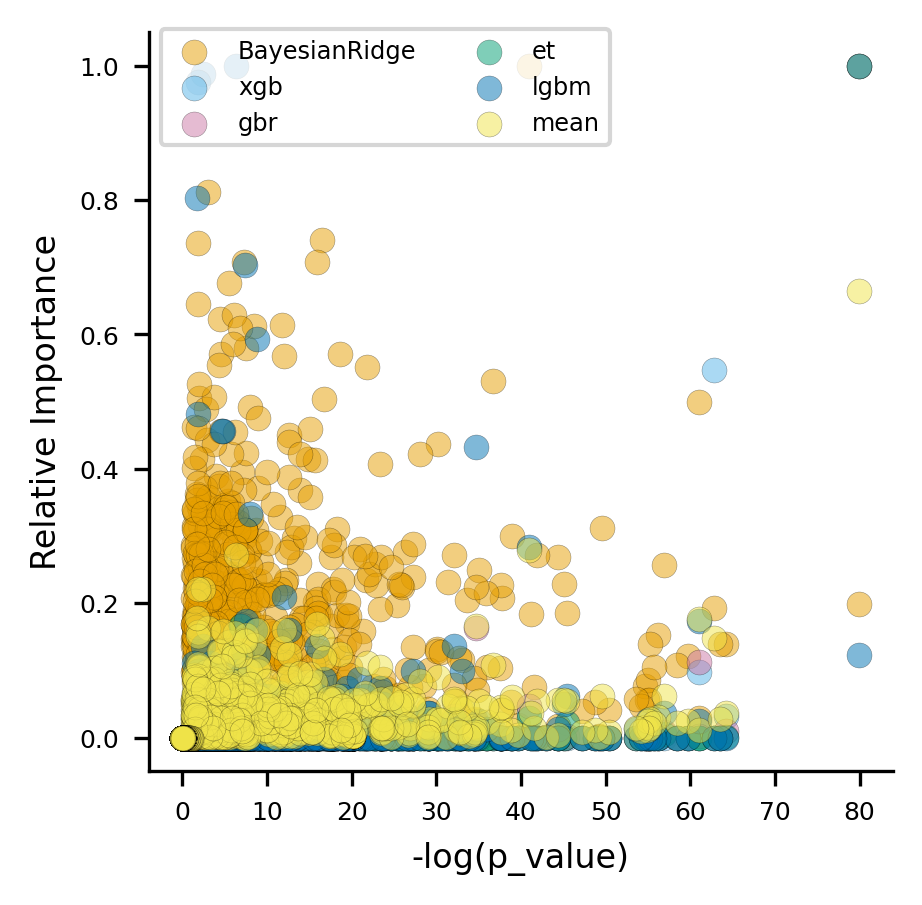

In [ ]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [ ]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

KeyError: 'mc'

In [ ]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [ ]:
tr = prep_pipeline[:4].fit_transform(tr)

ValueError: This SelectFdr estimator requires y to be passed, but the target y is None.

In [ ]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
               X_train=tr_hold, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

KeyError: 'mc'

In [ ]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=100,
                  figsize=(2.5, 3))

In [ ]:
from deepBreaks.utils import load_obj
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [ ]:
top_per_mod = report_dir + '/' + mtml[0] + '.pkl'
load_top_mod = load_obj(top_per_mod)

In [ ]:
print(f'Here is a list of your top performing models to test...\n{mtml}')

# <font color=red>STEP 4: Translate Candidate STSs</font> 
## This section is used to translate candidate STSs to the bovine or squid equivalent.
### The bovine and squid sequence dataframes that were saved earlier and are called again here


In [ ]:
import pandas as pd
import os

In [ ]:
#STEP 4: Translate Candidate STSs 
#translate candidate STSs to the bovine or squid equivalent 
#bovine and squid sequence dataframes were saved earlier and are called again here
m = 0
tm = ''
k=0
gaps=0
#import importance_report.csv from report_dir
true_pos = []
aa = []
tmd = []
df = pd.read_csv(f'{report_dir}\importance_report.csv')
#take the list of important sites and translate them to the bovine standard equivalent, 
#we do this by taking the site number and subtracting the number of '-' between the start of the sequence and the desired site. 
for rows in reference_seq.values:  
    rows = str(rows)
    #print(rows)
    if rows == 'nan':
    #We want to write the 'true_pos', 'aa', and 'TMD' to the 'importance_report' csv file
        gaps += 1
        k += 1
        true_pos.append('NA')
        aa.append('-')
        tmd.append('NA')
    else:
        #print("The number of gaps is " + str(gaps))
        k+=1
        trans_site = k - gaps
        if ref_seq_name == 'bovine':
            if trans_site in range(3,37):
                tm = 'N-Termina'
            elif trans_site in range(37,62):
                tm = '1'
            elif trans_site in range(74,96):
                tm = '2'
            elif trans_site in range(111,133):
                tm = '3'
            elif trans_site in range(153,174):
                tm = '4'
            elif trans_site in range(203,225):
                tm = '5'
            elif trans_site in range(253,275):
                tm = '6'
            elif trans_site in range(287,309):
                tm = '7'
            else:
                tm = 'CT/EC'
        else:
            if trans_site in range(3,34):
                tm = 'N-Termina'
            elif trans_site in range(34,59):
                tm = '1'
            elif trans_site in range(71,97):
                tm = '2'
            elif trans_site in range(110,132):
                tm = '3'
            elif trans_site in range(152,173):
                tm = '4'
            elif trans_site in range(200,225):
                tm = '5'
            elif trans_site in range(262,284):
                tm = '6'
            elif trans_site in range(294,315):
                tm = '7'
            else:
                tm = 'CT/EC'                
        
        true_pos.append(str(trans_site))
        aa.append(rows)
        tmd.append(tm)
true_pos.pop()
aa.pop()
tmd.pop()

df['true_position'] = true_pos
df['TMD'] = tmd
df['amino_acid'] = aa
df.to_csv(path_or_buf= os.path.join(report_dir,r'importance_report.csv'),index = 'Feature',mode="w")
#df.head()
